<h1>Softmax Regression on MNIST</h1>

<h3>Imports</h3>

In [130]:
import torch
import time
from torchvision import datasets, transforms
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Subset, ConcatDataset
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score


In [131]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

<h3>Preprocessing the data</h3>

In [132]:
# normalizing the dataset
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])


<h3>Downloading the dataset</h3>

In [133]:
train_val_dataset = datasets.MNIST(root='./dataset', train=True, download=False, transform=transform)
test_dataset = datasets.MNIST(root='./dataset', train=False, download=False, transform=transform)
combined_dataset = ConcatDataset([train_val_dataset, test_dataset])


In [134]:
print(f"Train dataset size: {len(train_val_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")
print(f"Combined dataset size: {len(combined_dataset)}")

Train dataset size: 60000
Test dataset size: 10000
Combined dataset size: 70000


<h3>HyperParameters</h3>

In [136]:
batch_size = 64   # change between 32, 64, 128, 256
num_classes = 10
input_size = 28 * 28
num_epochs = 20
l2_lambda = 0.0001

<h3>Splitting the data</h3>

In [137]:
# calculating split sizes
train_datset_size = int(0.6 * len(combined_dataset))
val_dataset_size = int(0.2 * len(combined_dataset))
test_dataset_size = len(combined_dataset) - train_datset_size - val_dataset_size

# printing split sizes
print(train_datset_size, val_dataset_size, test_dataset_size)

42000 14000 14000


In [138]:
# splitting the dataset
train_dataset_idx, temp_dataset_idx = train_test_split(list(range(len(combined_dataset))), train_size=train_datset_size, random_state=5)
val_dataset_idx, test_dataset_idx = train_test_split(temp_dataset_idx, test_size=0.5, random_state=5)

print(len(train_dataset_idx), len(val_dataset_idx), len(test_dataset_idx))

42000 14000 14000


In [139]:
# make subset of the dataset based on the split indices
train_dataset = Subset(combined_dataset, train_dataset_idx)
val_dataset = Subset(combined_dataset, val_dataset_idx)
test_dataset = Subset(combined_dataset, test_dataset_idx)

print(len(train_dataset), len(val_dataset), len(test_dataset))

42000 14000 14000


In [140]:
# creating dataloaders
train_dataset_loader = DataLoader(train_dataset, batch_size, shuffle=True)
val_dataset_loader = DataLoader(val_dataset, batch_size, shuffle=False)
test_dataset_loader = DataLoader(test_dataset, batch_size, shuffle=False)

print(len(train_dataset_loader), len(val_dataset_loader), len(test_dataset_loader))

657 219 219


In [141]:
x, y = next(iter(train_dataset_loader))

print(x.shape)  # [batch_size, channels, height, width]
print(y.shape)

torch.Size([64, 1, 28, 28])
torch.Size([64])


<h2>Softmax Regression Model</h2>

<h3>Define the softmax regression model</h3>

- Define the main layer, this is the main layer of the softmax regression model, which computes (Wx+b)
- MNIST images are 28x28 pixels, 10 classes
```
self.linear = torch.nn.Linear(input_size, num_classes)
```
- The forward pass that defines how the input data flows through the model

In [142]:
class SoftmaxRegressionModel(torch.nn.Module):
    def __init__(self, input_size, num_classes):
        super(SoftmaxRegressionModel, self).__init__() 
        self.linear = torch.nn.Linear(input_size, num_classes)

    def forward(self, x): # x is the input = image
        x = x.view(x.size(0), -1)  # Flatten the images from (batch_size, 1, 28, 28) to (batch_size, 784), express each example with a vector(784) instead of matrix 28*28
        return self.linear(x)

<h3>Training and Evaluation</h3>

<h5>Initialize model, loss function, and optimizer:</h5>
- Model: Softmax Regression <br/>
- Loss Function: Cross-Entropy <br/>
- Optimizer: Stochastic Gradient Descent (SGD) <br/>

- Training Loop: <br/>
```
for epoch in range(num_epochs):
    model.train()
```

- **y_train** is the ground truth label for the current batch
- **outputs** is the predicted label for the current batch

- clear the gradients of all optimized variables to prevent accumulation of gradients from previous batches
```
    optimizer.zero_grad()
```

- forward pass of the model on the current batch
```
    outputs = model(x_train)
```

- compute the loss between the predicted label (outputs) and the ground truth label (y_train)
```
    loss = criterion(outputs, y_train)
```

- compute the gradients of the loss with respect to the model parameters

```
loss.backward()
```
- update the model parameters based on the computed gradients
```
optimizer.step()
```

In [144]:
dict = {}
for lr in [0.1, 0.01, 0.001, 0.0001]:
    print(f"Learning rate: {lr}")
    model = SoftmaxRegressionModel(input_size, num_classes).to(device)
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    train_losses, train_accuracies, val_losses, val_accuracies = [], [], [], []

    for epoch in range(num_epochs):     # loop over the dataset num_epochs times
        print(f"Epoch {epoch+1}/{num_epochs}")
        model.train()
        epoch_train_loss = 0.0
        train_correct = 0
        train_total = 0
        
        for batch_idx, (x_train, y_train) in enumerate(train_dataset_loader):
            x_train, y_train = x_train.to(device), y_train.to(device)
            optimizer.zero_grad()
            
            # outputs = logits = values before softmax, with shape (batch_size, num_classes)
            outputs = model(x_train)
            batch_train_loss = criterion(outputs, y_train)
            
            # L2 regularization
            l2_norm = sum(p.pow(2.0).sum() for p in model.parameters()) # calculate the L2 norm of the model weights
            batch_train_loss = batch_train_loss + l2_lambda * l2_norm # add L2 regularization term to the loss
            
            predicted = torch.argmax(outputs, dim=1)
            train_total += y_train.size(0)
            train_correct += (predicted == y_train).sum().item()
            batch_train_loss.backward()     # dl/dwi
            optimizer.step()  # update weights, W = W - lr * gradient
            epoch_train_loss += batch_train_loss.item()   # update loss of current epoch with loss for current batch
            
        epoch_train_loss /= len(train_dataset_loader)
        train_losses.append(epoch_train_loss)
        train_accuracy = 100 * (train_correct / train_total)
        train_accuracies.append(train_accuracy)
        
        # Validation loop
        model.eval()
        epoch_val_loss = 0.0
        val_correct = 0
        val_total = 0 # total number of examples in the dataset
        
        with torch.no_grad():
            for x_val, y_val in val_dataset_loader:
                x_val, y_val = x_val.to(device), y_val.to(device)
                outputs = model(x_val)
                batch_val_loss = criterion(outputs, y_val)
                epoch_val_loss += batch_val_loss.item()
                _, predicted = torch.max(outputs.data, 1)
                val_total += y_val.size(0)
                val_correct += (predicted == y_val).sum().item()

        epoch_val_loss /= len(val_dataset_loader)
        val_losses.append(epoch_val_loss)
        val_accuracy = 100 * (val_correct / val_total)
        val_accuracies.append(val_accuracy)

    dict[lr] = (epoch_train_loss, train_accuracy, epoch_val_loss, val_accuracy)


Learning rate: 0.1
Epoch 1/1
Learning rate: 0.01
Epoch 1/1
Learning rate: 0.001
Epoch 1/1
Learning rate: 0.0001
Epoch 1/1


<h2>Visualizations</h2>

In [145]:
for lr in [0.1, 0.01, 0.001, 0.0001]:
    print(f"learning_rate = {lr}")
    print(f"Training Loss: {dict[lr][0]: .4f}")
    print(f"Training Accuracy: {dict[lr][1]: .4f}%")
    print(f"Validation Loss: {dict[lr][2]: .4f}")
    print(f"Validation Accuracy: {dict[lr][3]: .4f}%")
    print("-------------------------------------")


learning_rate = 0.1
Training Loss:  0.7891
Training Accuracy:  82.7476%
Validation Loss:  0.7770
Validation Accuracy:  76.3286%
-------------------------------------
learning_rate = 0.01
Training Loss:  0.6776
Training Accuracy:  83.2524%
Validation Loss:  0.4575
Validation Accuracy:  87.8500%
-------------------------------------
learning_rate = 0.001
Training Loss:  1.4766
Training Accuracy:  65.5286%
Validation Loss:  1.0300
Validation Accuracy:  80.9786%
-------------------------------------
learning_rate = 0.0001
Training Loss:  2.2497
Training Accuracy:  22.4071%
Validation Loss:  2.0997
Validation Accuracy:  32.1000%
-------------------------------------


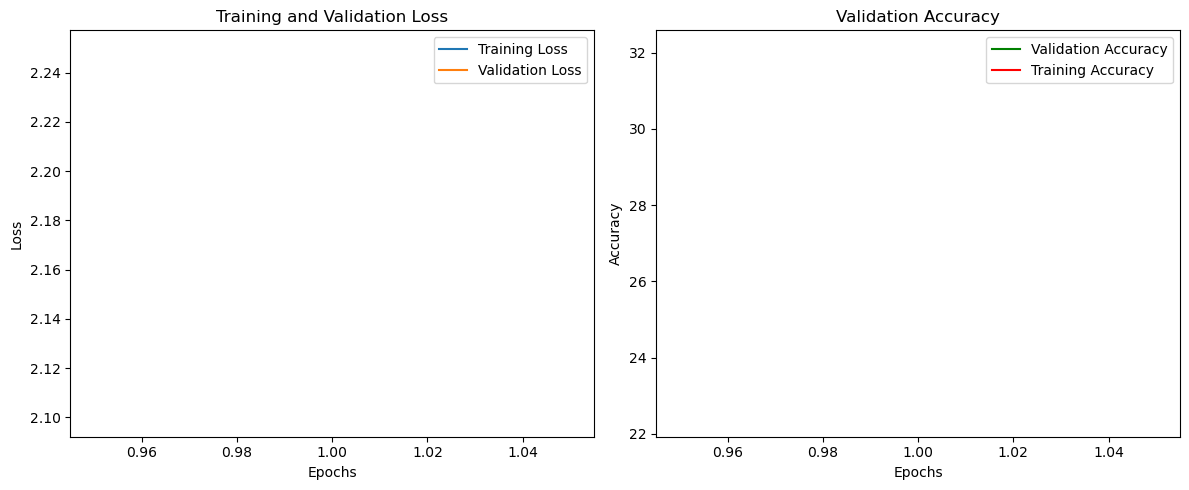

In [146]:
epochs = range(1, num_epochs + 1)

# Plot training and validation loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Training Loss')
plt.plot(epochs, val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, val_accuracies, label='Validation Accuracy', color='green')
plt.plot(epochs, train_accuracies, label='Training Accuracy', color='red')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

<h2>Confusion Matrix</h2>

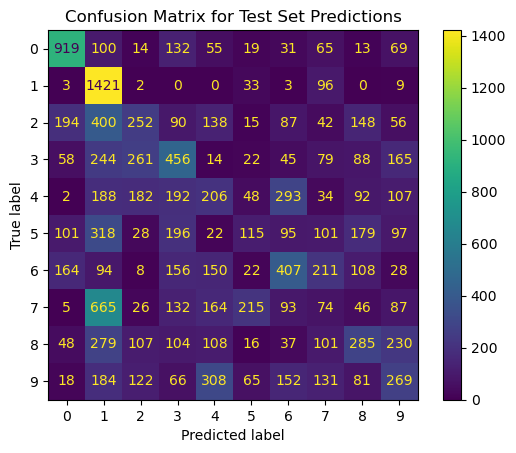

Accuracy on test set: 31.4571%


In [ ]:
# Evaluate on test set
model.eval()
y_true = []
y_pred = []

with torch.no_grad():
    for x_test, y_test in test_dataset_loader:
        x_test, y_test = x_test.to(device), y_test.to(device)
        outputs = model(x_test)
        _, predicted = torch.max(outputs, 1)
        y_true.extend(y_test.cpu().numpy()) # convert to numpy array from tensor
        y_pred.extend(predicted.cpu().numpy())

# Generate confusion matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(range(num_classes)))

# Plot confusion matrix
disp.plot(cmap='viridis', values_format='d')
plt.title("Confusion Matrix for Test Set Predictions")
plt.show()

print("-------------------------------------")
accuracy = accuracy_score(y_true, y_pred)
print(f"Accuracy on test set: {accuracy * 100:.4f}%")